In [1]:
from desdeo_emo.surrogatemodelling import BioGP, EvoNN
from desdeo_problem.surrogatemodels.SurrogateModels import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

from desdeo_problem.Problem import DataProblem

from desdeo_problem.testproblems.TestProblems import test_problem_builder

from desdeo_emo.EAs import NSGAIII, RVEA, PPGA


from desdeo_emo.othertools.plotlyanimate import animate_init_, animate_next_
import plotly.express as ex

from plotly import graph_objects as go
import numpy as np
import pandas as pd
from pyDOE import lhs
from pygmo import non_dominated_front_2d as nd2

In [2]:
# Creating the data to be modelled. Based on Coello MOP7 functions.

def f_1(x):
    term1 = ((x[:,0] - 2) ** 2) / 2
    term2 = ((x[:,1] + 1) ** 2) / 13
    return term1 + term2 + 3

def f_2(x):
    term1 = ((x[:, 0] + x[:, 1] - 3) ** 2) / 36
    term2 = ((-x[:, 0] + x[:, 1] + 2) ** 2) / 8
    return term1 + term2 - 17

def f_3(x):
    term1 = ((x[:, 0] + (2 * x[:, 1]) - 1) ** 2) / 175
    term2 = ((-x[:, 0] + 2* x[:, 1]) ** 2) / 17
    return term1 + term2 - 13

# Decision variables
x = lhs(2, 1000)  # 2 Columns, 500 data points
x = (x - 0.5) * 800  # Rescaling to [-400, 400]

f1 = f_1(x)
f2 = f_2(x)
f3 = f_3(x)

f = np.vstack((f1, f2, f3)).T

data = pd.DataFrame(np.hstack((x, f)), columns= ["x", "y", "f1", "f2", "f3"])

In [3]:
data

,x,y,f1,f2,f3
0,-89.671535,-285.524807,10432.094075,8653.510619,16120.015955
1,88.367531,-375.069752,14496.381326,28929.861840,43855.568845
2,-208.210060,-399.773045,34329.437945,14844.219969,26371.105919
3,78.437948,-321.458560,10823.894481,21454.485606,32423.246137
4,26.007263,-282.703453,6395.546318,13615.324943,22230.501262
...,...,...,...,...,...
995,-344.337708,118.159714,61070.137517,28411.691668,19888.014781
996,-137.687627,-196.222971,12691.009540,3535.551515,5416.769300
997,51.796144,-298.695901,8059.970268,16898.557354,26485.120732
998,-0.076294,-262.761227,5275.843167,10440.623355,17812.410980


In [4]:
problem = DataProblem(data=data, variable_names=["x", "y"], objective_names=["f1", "f2", "f3"])

In [6]:
problem.train(EvoNN, 
              model_parameters={
                  "training_algorithm":PPGA, 
                  "pop_size":50,
                  "num_hidden_nodes":25,
              })
# How to use hyperparameters
#problem.train(EvoNNforDESDEO, model_parameters={"training_algorithm":NSGAIII, "pop_size": 50})

Plot saved as:  EvoNN.html
View the plot by opening the file in browser.
To view the plot in Jupyter Notebook, use the IFrame command.
Plot saved as:  EvoNN.html
View the plot by opening the file in browser.
To view the plot in Jupyter Notebook, use the IFrame command.
Plot saved as:  EvoNN.html
View the plot by opening the file in browser.
To view the plot in Jupyter Notebook, use the IFrame command.


In [15]:
evolver = NSGAIII(problem, n_gen_per_iter=100, use_surrogates=True)
figure = animate_init_(evolver.population.objectives, filename="example.html")

while evolver.continue_evolution():
    evolver.iterate()
    figure = animate_next_(
        evolver.population.objectives,
        figure,
        filename="example.html",
        generation=evolver._iteration_counter,
    )

Plot saved as:  example.html
View the plot by opening the file in browser.
To view the plot in Jupyter Notebook, use the IFrame command.


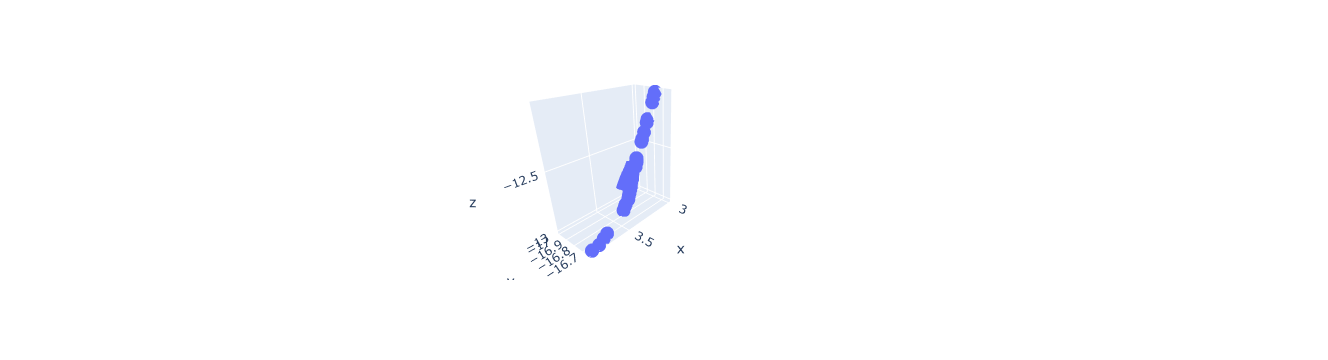

In [16]:
ex.scatter_3d(x=f_1(evolver.population.individuals),
             y=f_2(evolver.population.individuals),
             z=f_3(evolver.population.individuals),
             )

In [18]:
ind = pd.DataFrame(evolver.population.individuals, columns=["x", "y"])

In [32]:
pred_obj = pd.DataFrame(evolver.population.objectives, columns=["f1", "f2", "f3"])

In [2]:
#Uncomment the following when running the code
"""pred_front_true_val = pd.DataFrame(
    np.vstack(
        (
            f_1(evolver.population.individuals),
            f_2(evolver.population.individuals),
            f_3(evolver.population.individuals)
        )
    ).T,
    columns=["f1", "f2", "f3"])"""
#Plotting saved results. Comment if you are re-running the experiment
pred_front_true_val = pd.read_csv("MOP7_true_obj.csv", index_col=0)

In [37]:
fig = go.Figure()

fig.add_scatter3d(
    x=pred_front_true_val["f1"],
    y=pred_front_true_val["f2"],
    z=pred_front_true_val["f3"],
    mode="markers",
    marker_line_width=8,
    marker=dict(size=10)
)
fig.update_layout(scene = dict(
                    xaxis_title='<b>f1</b>',
                    yaxis_title='<b>f2</b>',
                    zaxis_title='<b>f3</b>',
                    xaxis = dict(nticks=7, range=[2.9,4.2],),
                    yaxis = dict(nticks=6, range=[-17.05,-16.5],),
                    zaxis = dict(nticks=6, range=[-13.05,-12],),),
                  font_size=15
                 )
fig.update_layout(template="ggplot2", scene_aspectmode='cube')

fig.write_html("pred_MOP7.html")


In [38]:
true_obj= pd.read_csv("MOP7_true_front.csv", index_col=0)
fig2 = go.Figure()

fig2.add_scatter3d(
    x=true_obj.values[:, 0],
    y=true_obj.values[:, 1],
    z=true_obj.values[:, 2],
    mode="markers",
    marker_line_width=8,
    marker=dict(size=10)
)
fig2.update_layout(scene = dict(
                    xaxis_title='<b>f1</b>',
                    yaxis_title='<b>f2</b>',
                    zaxis_title='<b>f3</b>',
                    xaxis = dict(nticks=7, range=[2.9,4.2],),
                    yaxis = dict(nticks=6, range=[-17.05,-16.5],),
                    zaxis = dict(nticks=6, range=[-13.05,-12],),),
                  font_size=15
                 )
fig2.update_layout(template="ggplot2", scene_aspectmode='cube')

fig2.write_html("true_MOP7.html")

In [78]:
true_obj

,0,1,2
0,3.102516,-16.963163,-12.831023
1,3.073589,-16.961580,-12.757665
2,4.085249,-16.524693,-12.999697
3,3.349105,-16.812837,-12.980479
4,3.132532,-16.960751,-12.884663
...,...,...,...
495,3.108519,-16.981290,-12.821543
496,3.144156,-16.988509,-12.846591
497,3.205440,-16.913683,-12.950222
498,3.197885,-16.978114,-12.905683
